# Imports

In [17]:
import itertools
import os

import joblib
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf


from datetime import datetime
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from tensorflow.keras.layers import (Input, Dense, LayerNormalization, Dropout,
                                     MultiHeadAttention, Layer)
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau



# Utils

## Data Utils

In [18]:
def load_data(base_path, weeks, file_type='input'):
    all_dfs = []
    for week in weeks:
        file_name = f"{file_type}_2023_w{str(week).zfill(2)}.csv"
        file_path = os.path.join(base_path, file_name)
        if os.path.exists(file_path):
            df = pd.read_csv(file_path)
            df['week'] = week
            all_dfs.append(df)
    if not all_dfs: return pd.DataFrame()
    return pd.concat(all_dfs, ignore_index=True)

## Feature Engineering Utils

In [19]:
def convert_height_to_inches(height_str):
    try:
        feet, inches = map(int, str(height_str).split('-'))
        return feet * 12 + inches
    except: return np.nan

def calculate_age(birth_date_str, current_date=datetime(2024, 1, 1)):
    try:
        birth_date = datetime.strptime(str(birth_date_str), '%Y-%m-%d')
        return (current_date - birth_date).days / 365.25
    except: return np.nan

def feature_engineering(df):
    df['player_height_inches'] = df['player_height'].apply(convert_height_to_inches)
    df['player_age'] = df['player_birth_date'].apply(calculate_age)
    df['dist_to_land_spot'] = np.sqrt((df['x'] - df['ball_land_x'])**2 + (df['y'] - df['ball_land_y'])**2)
    df['delta_x_to_land'] = df['ball_land_x'] - df['x']
    df['delta_y_to_land'] = df['ball_land_y'] - df['y']
    dir_rad = np.deg2rad(df['dir'])
    df['vx'] = df['s'] * np.cos(dir_rad)
    df['vy'] = df['s'] * np.sin(dir_rad)
    return df

## Preprocessing Utils

In [20]:
def create_sequences(input_df, output_df, features_to_use, max_input_len, max_output_len, is_test=False):
    unique_plays = input_df[['game_id', 'play_id', 'nfl_id']].drop_duplicates()
    
    encoder_input_data = []
    decoder_output_data = [] # Apenas para treino/validação
    play_identifiers = [] # Para mapear previsões de volta

    for _, row in unique_plays.iterrows():
        game_id, play_id, nfl_id = row['game_id'], row['play_id'], row['nfl_id']
        
        input_seq = input_df[(input_df['game_id'] == game_id) & (input_df['play_id'] == play_id) & (input_df['nfl_id'] == nfl_id)]
        input_features = input_seq[features_to_use].values
        
        padded_input = np.zeros((max_input_len, len(features_to_use)))
        seq_len = min(len(input_features), max_input_len)
        padded_input[-seq_len:] = input_features[-seq_len:]
        encoder_input_data.append(padded_input)
        play_identifiers.append((game_id, play_id, nfl_id, input_seq['num_frames_output'].iloc[0]))
        
        if not is_test:
            output_seq = output_df[(output_df['game_id'] == game_id) & (output_df['play_id'] == play_id) & (output_df['nfl_id'] == nfl_id)]
            output_coords = output_seq[['x', 'y']].values
            
            padded_output = np.zeros((max_output_len, 2))
            seq_len_out = min(len(output_coords), max_output_len)
            if seq_len_out > 0:
                padded_output[:seq_len_out] = output_coords[:seq_len_out]
            decoder_output_data.append(padded_output)

    if is_test:
        return np.array(encoder_input_data), play_identifiers
    else:
        return np.array(encoder_input_data), np.array(decoder_output_data)

## Model Utils

In [21]:
class PositionalEncoding(Layer):
    """
    Injeta informação sobre a posição relativa ou absoluta dos tokens na sequência.
    """
    def __init__(self, position, d_model):
        super(PositionalEncoding, self).__init__()
        self.pos_encoding = self.positional_encoding(position, d_model)

    def get_angles(self, position, i, d_model):
        angles = 1 / tf.pow(10000, (2 * (i // 2)) / tf.cast(d_model, tf.float32))
        return position * angles

    def positional_encoding(self, position, d_model):
        angle_rads = self.get_angles(
            tf.range(position, dtype=tf.float32)[:, tf.newaxis],
            tf.range(d_model, dtype=tf.float32)[tf.newaxis, :],
            d_model
        )
        # aplica seno nos índices pares
        angle_rads_even = tf.math.sin(angle_rads[:, 0::2])
        # aplica cosseno nos índices ímpares
        angle_rads_odd = tf.math.cos(angle_rads[:, 1::2])

        pos_encoding = tf.concat([angle_rads_even, angle_rads_odd], axis=-1)
        pos_encoding = pos_encoding[tf.newaxis, ...]
        return tf.cast(pos_encoding, tf.float32)

    def call(self, inputs):
        return inputs + self.pos_encoding[:, :tf.shape(inputs)[1], :]

In [22]:
def transformer_encoder_layer(units, d_model, num_heads, dropout, name="encoder_layer"):
    inputs = Input(shape=(None, d_model), name="inputs")
    
    # Multi-Head Attention
    attention = MultiHeadAttention(
        num_heads=num_heads, key_dim=d_model, name="attention")(inputs, inputs)
    attention = Dropout(dropout)(attention)
    attention = LayerNormalization(epsilon=1e-6)(inputs + attention)

    # Feed Forward Network
    outputs = Dense(units=units, activation="relu")(attention)
    outputs = Dense(units=d_model)(outputs)
    outputs = Dropout(dropout)(outputs)
    outputs = LayerNormalization(epsilon=1e-6)(attention + outputs)

    return Model(inputs=inputs, outputs=outputs, name=name)

In [23]:
def transformer_decoder_layer(units, d_model, num_heads, dropout, name="decoder_layer"):
    inputs = Input(shape=(None, d_model), name="inputs")
    enc_outputs = Input(shape=(None, d_model), name="encoder_outputs")

    # Masked Multi-Head Attention (Self-Attention)
    attention1 = MultiHeadAttention(
        num_heads=num_heads, key_dim=d_model, name="attention_1")(inputs, inputs, use_causal_mask=True)
    attention1 = LayerNormalization(epsilon=1e-6)(inputs + attention1)
    
    # Multi-Head Attention (Cross-Attention)
    attention2 = MultiHeadAttention(
        num_heads=num_heads, key_dim=d_model, name="attention_2")(attention1, enc_outputs)
    attention2 = Dropout(dropout)(attention2)
    attention2 = LayerNormalization(epsilon=1e-6)(attention1 + attention2)

    # Feed Forward Network
    outputs = Dense(units=units, activation="relu")(attention2)
    outputs = Dense(units=d_model)(outputs)
    outputs = Dropout(dropout)(outputs)
    outputs = LayerNormalization(epsilon=1e-6)(attention2 + outputs)

    return Model(inputs=[inputs, enc_outputs], outputs=outputs, name=name)

In [24]:
def build_transformer_model(input_vocab_size, target_vocab_size, max_seq_len, d_model=128, num_heads=8,
                            num_encoder_layers=4, num_decoder_layers=4, dff=512, dropout=0.1):
    """Constrói o modelo Transformer Encoder-Decoder completo."""
    
    # --- Inputs ---
    encoder_inputs = Input(shape=(None, input_vocab_size), name="encoder_inputs")
    decoder_inputs = Input(shape=(None, target_vocab_size), name="decoder_inputs")

    # --- Embeddings + Positional Encoding ---
    encoder_embedding = Dense(d_model, name="encoder_embedding")(encoder_inputs)
    encoder_embedding = PositionalEncoding(max_seq_len, d_model)(encoder_embedding)
    
    decoder_embedding = Dense(d_model, name="decoder_embedding")(decoder_inputs)
    decoder_embedding = PositionalEncoding(max_seq_len, d_model)(decoder_embedding)

    # --- Encoder ---
    enc_outputs = Dropout(dropout)(encoder_embedding)
    for i in range(num_encoder_layers):
        enc_outputs = transformer_encoder_layer(dff, d_model, num_heads, dropout, name=f"encoder_layer_{i}")(enc_outputs)

    # --- Decoder ---
    dec_outputs = Dropout(dropout)(decoder_embedding)
    for i in range(num_decoder_layers):
        dec_outputs = transformer_decoder_layer(dff, d_model, num_heads, dropout, name=f"decoder_layer_{i}")([dec_outputs, enc_outputs])
    
    # --- Output Layer ---
    final_output = Dense(target_vocab_size, name="final_output")(dec_outputs)

    return Model(inputs=[encoder_inputs, decoder_inputs], outputs=final_output)

In [25]:
def run_training_pipeline(config):
    """Função principal que encapsula todo o processo de treinamento."""
    
    PROCESSED_DATA_PATH = 'processed_training_data.npz'

    # --- LÓGICA DE CARREGAMENTO ---
    # Verifica se os dados processados já existem
    if not os.path.exists(PROCESSED_DATA_PATH):
        print("Dados pré-processados não encontrados. Executando o pipeline completo...")
        # --- Carregamento de TODOS os dados de treino ---
        print("Carregando dados de treinamento (Semanas 1-18)...")
        input_df = load_data(config['BASE_PATH'], range(1, 19), 'input')
        output_df = load_data(config['BASE_PATH'], range(1, 19), 'output')
        
        # --- Engenharia de Atributos ---
        print("Executando engenharia de atributos...")
        input_df = feature_engineering(input_df)

        # --- Definição do Pré-processador ---
        numeric_features = ['x', 'y', 's', 'a', 'player_height_inches', 'player_age', 'dist_to_land_spot', 'delta_x_to_land', 'delta_y_to_land', 'vx', 'vy']
        categorical_features = ['play_direction', 'player_position', 'player_side', 'player_role']
        
        preprocessor = ColumnTransformer(
            transformers=[
                ('num', StandardScaler(), numeric_features),
                ('cat', OneHotEncoder(handle_unknown='ignore', sparse_output=False), categorical_features)
            ], remainder='drop'
        )
        
        # --- Divisão Treino/Validação por semana ---
        train_df = input_df[input_df['week'].isin(config['TRAIN_WEEKS'])]
        val_df = input_df[input_df['week'].isin(config['VALIDATION_WEEKS'])]
        
        # AJUSTAR ('fit') o preprocessor APENAS nos dados de treino
        print("Ajustando o pré-processador nos dados de treino...")
        preprocessor.fit(train_df[numeric_features + categorical_features])
        
        # Salvar o preprocessor para uso na inferência
        joblib.dump(preprocessor, 'preprocessor.joblib')
        
        # Aplicar a transformação
        processed_train_data = preprocessor.transform(train_df[numeric_features + categorical_features])
        processed_val_data = preprocessor.transform(val_df[numeric_features + categorical_features])
        
        feature_names = preprocessor.get_feature_names_out()
        
        processed_train_df = pd.DataFrame(processed_train_data, columns=feature_names, index=train_df.index)
        processed_val_df = pd.DataFrame(processed_val_data, columns=feature_names, index=val_df.index)
        
        id_cols = ['game_id', 'play_id', 'nfl_id', 'num_frames_output']
        final_train_df = pd.concat([train_df[id_cols], processed_train_df], axis=1)
        final_val_df = pd.concat([val_df[id_cols], processed_val_df], axis=1)

        # --- Criação de Sequências ---
        print("Criando sequências de treino e validação...")
        X_enc_train, y_dec_train = create_sequences(final_train_df, output_df, feature_names, config['MAX_INPUT_LEN'], config['MAX_OUTPUT_LEN'])
        X_enc_val, y_dec_val = create_sequences(final_val_df, output_df, feature_names, config['MAX_INPUT_LEN'], config['MAX_OUTPUT_LEN'])

        print(f"Salvando dados pré-processados em '{PROCESSED_DATA_PATH}'...")
        np.savez_compressed(
            PROCESSED_DATA_PATH,
            X_enc_train=X_enc_train,
            y_dec_train=y_dec_train,
            X_enc_val=X_enc_val,
            y_dec_val=y_dec_val
        )
        print("Dados salvos com sucesso para uso futuro.")
        
    else:
        print(f"Carregando dados pré-processados de '{PROCESSED_DATA_PATH}'...")
        processed_data = np.load(PROCESSED_DATA_PATH)
        X_enc_train = processed_data['X_enc_train']
        y_dec_train = processed_data['y_dec_train']
        X_enc_val = processed_data['X_enc_val']
        y_dec_val = processed_data['y_dec_val']
        print("Dados carregados com sucesso.") 
    
    # Input do decoder para teacher forcing
    dec_input_train = np.zeros_like(y_dec_train); dec_input_train[:, 1:, :] = y_dec_train[:, :-1, :]
    dec_input_val = np.zeros_like(y_dec_val); dec_input_val[:, 1:, :] = y_dec_val[:, :-1, :]

    # --- Construção e Compilação do Modelo ---
    tf.keras.backend.clear_session()
    
    input_vocab_size = X_enc_train.shape[-1] # Número de features de entrada
    target_vocab_size = y_dec_train.shape[-1] # Número de features de saída (2, para x e y)
    max_seq_len = max(X_enc_train.shape[1], y_dec_train.shape[1])

    model = build_transformer_model(
        input_vocab_size=input_vocab_size,
        target_vocab_size=target_vocab_size,
        max_seq_len=max_seq_len,
        d_model=config['D_MODEL'],
        num_heads=config['NUM_HEADS'],
        dff=config['DFF']
    )
    
    optimizer = Adam(learning_rate=config['LEARNING_RATE'], beta_1=0.9, beta_2=0.98, epsilon=1e-9)
    model.compile(optimizer=optimizer, loss='mse', metrics=[tf.keras.metrics.RootMeanSquaredError()])
    model.summary()
    
    callbacks = [
        EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True),
        ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5)
    ]
    
    print("\nIniciando o treinamento do modelo Transformer...")
    history = model.fit(
        [X_enc_train, dec_input_train], y_dec_train,
        batch_size=config['BATCH_SIZE'],
        epochs=config['EPOCHS'],
        validation_data=([X_enc_val, dec_input_val], y_dec_val),
        callbacks=callbacks
    )
    
    model.save(config['MODEL_NAME'] + '.keras')
    print("Treinamento concluído e modelo salvo como 'transformer_model.h5'")
    return model, history

## Submission Utils

In [26]:
def predict_and_format_submission(config):
    """Carrega os dados de teste, aplica o pipeline e gera a submissão."""
    print("\nIniciando pipeline de inferência...")

    PROCESSED_TEST_PATH_NPZ = 'processed_test_data.npz'
    PROCESSED_TEST_PATH_PKL = 'play_identifiers.pkl'
    
    if not os.path.exists(PROCESSED_TEST_PATH_NPZ) and os.path.exists(PROCESSED_TEST_PATH_PKL):
        # --- Carregar Dados de Teste e Modelos ---
        test_input_df = pd.read_csv(os.path.join(config['BASE_PATH'], 'test_input.csv'))
        # O arquivo 'test.csv' contém os IDs que precisam ser previstos, útil para validação do formato
        test_ids_df = pd.read_csv(os.path.join(config['BASE_PATH'], 'test.csv'))

        encoder_model = tf.keras.models.load_model('encoder_model.h5')
        decoder_model = tf.keras.models.load_model('decoder_model.h5')
        preprocessor = joblib.load('preprocessor.joblib')

        # --- Pré-processamento e Engenharia de Atributos ---
        test_input_df = feature_engineering(test_input_df)
        
        numeric_features = ['x', 'y', 's', 'a', 'player_height_inches', 'player_age', 'dist_to_land_spot', 'delta_x_to_land', 'delta_y_to_land', 'vx', 'vy']
        categorical_features = ['play_direction', 'player_position', 'player_side', 'player_role']
        feature_names = preprocessor.get_feature_names_out()
        
        # Aplicar o pré-processador JÁ AJUSTADO
        processed_test_data = preprocessor.transform(test_input_df[numeric_features + categorical_features])
        processed_test_df = pd.DataFrame(processed_test_data, columns=feature_names, index=test_input_df.index)
        
        id_cols = ['game_id', 'play_id', 'nfl_id', 'num_frames_output']
        final_test_df = pd.concat([test_input_df[id_cols], processed_test_df], axis=1)

        # --- Criar Sequências de Teste ---
        X_enc_test, play_identifiers = create_sequences(final_test_df, None, feature_names, config['MAX_INPUT_LEN'], config['MAX_OUTPUT_LEN'], is_test=True)
        
        print("Salvando dados de teste pré-processados...")
        np.savez_compressed(PROCESSED_TEST_PATH_NPZ, X_enc_test=X_enc_test)
        with open(PROCESSED_TEST_PATH_PKL, 'wb') as f:
            joblib.dump(play_identifiers, f)
    else:
        print("Carregando dados de teste pré-processados do disco...")
        processed_data = np.load(PROCESSED_TEST_PATH_NPZ)
        X_enc_test = processed_data['X_enc_test']
        
        with open(PROCESSED_TEST_PATH_PKL, 'rb') as f:
            play_identifiers = joblib.load(f)

    # --- Gerar Previsões (Loop de Inferência) ---
    predictions = []
    for i in range(len(X_enc_test)):
        input_seq = X_enc_test[i:i+1]
        states_value = encoder_model.predict(input_seq, verbose=0)
        
        target_seq = np.zeros((1, 1, 2)) # Começa com (0,0)
        
        num_frames_to_predict = play_identifiers[i][3]
        output_sequence = []

        for _ in range(num_frames_to_predict):
            output_tokens, h, c = decoder_model.predict([target_seq] + states_value, verbose=0)
            output_sequence.append(output_tokens[0, 0, :])
            target_seq = output_tokens
            states_value = [h, c]
        
        predictions.append(output_sequence)
        
    # --- Formatar para Submissão ---
    submission_rows = []
    for i, play_info in enumerate(play_identifiers):
        game_id, play_id, nfl_id, num_frames = play_info
        predicted_trajectory = predictions[i]
        for frame_idx, coords in enumerate(predicted_trajectory):
            frame_id = frame_idx + 1
            row_id = f"{game_id}_{play_id}_{nfl_id}_{frame_id}"
            submission_rows.append({'id': row_id, 'x': coords[0], 'y': coords[1]})

    submission_df = pd.DataFrame(submission_rows)
    submission_df.to_csv('submission.csv', index=False)
    
    print(f"Arquivo 'submission.csv' gerado com {len(submission_df)} linhas.")

## Plot Utils

In [27]:
def plot_training_history(history):
    """
    Plota os gráficos de perda e RMSE do treinamento e validação.
    
    Args:
        history: O objeto history retornado pelo model.fit() do Keras.
    """
    # Dados de Perda (Loss - Mean Squared Error)
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    
    # Dados da Métrica (Root Mean Squared Error)
    rmse = history.history['root_mean_squared_error']
    val_rmse = history.history['val_root_mean_squared_error']
    
    epochs = range(1, len(loss) + 1)
    
    # Criar a figura com dois subplots (um para Loss, um para RMSE)
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))
    
    # Plotar o gráfico de Perda (Loss)
    ax1.plot(epochs, loss, 'bo-', label='Perda de Treinamento')
    ax1.plot(epochs, val_loss, 'ro-', label='Perda de Validação')
    ax1.set_title('Perda (MSE) de Treinamento e Validação')
    ax1.set_xlabel('Épocas')
    ax1.set_ylabel('Perda (MSE)')
    ax1.legend()
    ax1.grid(True)
    
    # Plotar o gráfico da Métrica (RMSE)
    ax2.plot(epochs, rmse, 'bo-', label='RMSE de Treinamento')
    ax2.plot(epochs, val_rmse, 'ro-', label='RMSE de Validação')
    ax2.set_title('Métrica (RMSE) de Treinamento e Validação')
    ax2.set_xlabel('Épocas')
    ax2.set_ylabel('RMSE')
    ax2.legend()
    ax2.grid(True)
    
    plt.tight_layout()
    plt.savefig('training_history.png') # Salva a imagem em um arquivo
    print("Gráfico do histórico de treinamento salvo como 'training_history.png'")

# Train Data

In [28]:
config_transformer = {
        'BASE_PATH': './nfl-big-data-bowl-2026-prediction/train',
        'TRAIN_WEEKS': range(1, 16),
        'VALIDATION_WEEKS': range(16, 19),
        'MAX_INPUT_LEN': 30,
        'MAX_OUTPUT_LEN': 40,
        'BATCH_SIZE': 8,
        'EPOCHS': 50,
        'LEARNING_RATE': 0.0002,
        'D_MODEL': 64,   # Dimensão do modelo (tem que ser divisível por NUM_HEADS)
        'NUM_HEADS': 8,  # Número de cabeças de atenção
        'DFF': 256,      # Dimensão da camada Feed-Forward interna
        'MODEL_NAME': 'transformer_model_D64'
    }

model, history = run_training_pipeline(config_transformer)

Carregando dados pré-processados de 'processed_training_data.npz'...


Dados carregados com sucesso.


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ encoder_inputs      │ (None, None, 35)  │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ encoder_embedding   │ (None, None, 64)  │      2,304 │ encoder_inputs[0… │
│ (Dense)             │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ positional_encoding │ (None, None, 64)  │          0 │ encoder_embeddin… │
│ (PositionalEncodin… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, None, 64)  │          0 │ positional_encod… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ decoder_inputs      │ (None, None, 2)   │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ encoder_layer_0     │ (None, None, 64)  │    166,016 │ dropout[0][0]     │
│ (Functional)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ decoder_embedding   │ (None, None, 64)  │        192 │ decoder_inputs[0… │
│ (Dense)             │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ encoder_layer_1     │ (None, None, 64)  │    166,016 │ encoder_layer_0[… │
│ (Functional)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ positional_encodin… │ (None, None, 64)  │          0 │ decoder_embeddin… │
│ (PositionalEncodin… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ encoder_layer_2     │ (None, None, 64)  │    166,016 │ encoder_layer_1[… │
│ (Functional)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_13          │ (None, None, 64)  │          0 │ positional_encod… │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ encoder_layer_3     │ (None, None, 64)  │    166,016 │ encoder_layer_2[… │
│ (Functional)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ decoder_layer_0     │ (None, None, 64)  │    298,816 │ dropout_13[0][0], │
│ (Functional)        │                   │            │ encoder_layer_3[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ decoder_layer_1     │ (None, None, 64)  │    298,816 │ decoder_layer_0[… │
│ (Functional)        │                   │            │ encoder_layer_3[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ decoder_layer_2     │ (None, None, 64)  │    298,816 │ decoder_layer_1[… │
│ (Functional)        │                   │            │ encoder_layer_3[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ decoder_layer_3     │ (None, None, 64)  │    298,816 │ decoder_layer_2[… │
│ (Functional)        │                   │            │ encoder_layer_3[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ final_output        │ (None, None, 2)   │        130 │ decoder_layer_3[… │
│ (Dense)             │                   │            │                 

 Total params: 1,861,954 (7.10 MB)

 Trainable params: 1,861,954 (7.10 MB)

 Non-trainable params: 0 (0.00 B)


Iniciando o treinamento do modelo Transformer...


2025-10-05 00:33:29.997386: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:84] Allocation of 601351800 exceeds 10% of free system memory.
2025-10-05 00:33:33.463220: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:84] Allocation of 601351800 exceeds 10% of free system memory.


Epoch 1/50


2025-10-05 00:34:00.600681: I external/local_xla/xla/service/gpu/autotuning/dot_search_space.cc:208] All configs were filtered out because none of them sufficiently match the hints. Maybe the hints set does not contain a good representative set of valid configs? Working around this by using the full hints set instead.
2025-10-05 00:34:00.600875: I external/local_xla/xla/service/gpu/autotuning/dot_search_space.cc:208] All configs were filtered out because none of them sufficiently match the hints. Maybe the hints set does not contain a good representative set of valid configs? Working around this by using the full hints set instead.
2025-10-05 00:34:00.600983: I external/local_xla/xla/service/gpu/autotuning/dot_search_space.cc:208] All configs were filtered out because none of them sufficiently match the hints. Maybe the hints set does not contain a good representative set of valid configs? Working around this by using the full hints set instead.
2025-10-05 00:34:00.601066: I external/l

17897/17898 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 49.5287 - root_mean_squared_error: 6.8174

2025-10-05 00:38:35.918430: I external/local_xla/xla/service/gpu/autotuning/dot_search_space.cc:208] All configs were filtered out because none of them sufficiently match the hints. Maybe the hints set does not contain a good representative set of valid configs? Working around this by using the full hints set instead.
2025-10-05 00:38:35.918509: I external/local_xla/xla/service/gpu/autotuning/dot_search_space.cc:208] All configs were filtered out because none of them sufficiently match the hints. Maybe the hints set does not contain a good representative set of valid configs? Working around this by using the full hints set instead.
2025-10-05 00:38:35.918608: I external/local_xla/xla/service/gpu/autotuning/dot_search_space.cc:208] All configs were filtered out because none of them sufficiently match the hints. Maybe the hints set does not contain a good representative set of valid configs? Working around this by using the full hints set instead.
2025-10-05 00:38:35.918692: I external/l

17898/17898 ━━━━━━━━━━━━━━━━━━━━ 362s 17ms/step - loss: 26.7890 - root_mean_squared_error: 5.1758 - val_loss: 17.1160 - val_root_mean_squared_error: 4.1372 - learning_rate: 2.0000e-04
Epoch 2/50
17898/17898 ━━━━━━━━━━━━━━━━━━━━ 291s 16ms/step - loss: 14.9493 - root_mean_squared_error: 3.8664 - val_loss: 14.8920 - val_root_mean_squared_error: 3.8590 - learning_rate: 2.0000e-04
Epoch 3/50
17898/17898 ━━━━━━━━━━━━━━━━━━━━ 272s 15ms/step - loss: 14.4239 - root_mean_squared_error: 3.7979 - val_loss: 15.3052 - val_root_mean_squared_error: 3.9122 - learning_rate: 2.0000e-04
Epoch 4/50
17898/17898 ━━━━━━━━━━━━━━━━━━━━ 267s 15ms/step - loss: 14.0940 - root_mean_squared_error: 3.7542 - val_loss: 15.0488 - val_root_mean_squared_error: 3.8793 - learning_rate: 2.0000e-04
Epoch 5/50
17898/17898 ━━━━━━━━━━━━━━━━━━━━ 266s 15ms/step - loss: 13.8930 - root_mean_squared_error: 3.7273 - val_loss: 13.8490 - val_root_mean_squared_error: 3.7214 - learning_rate: 2.0000e-04
Epoch 6/50
17898/17898 ━━━━━━━━━━━━━

Gráfico do histórico de treinamento salvo como 'training_history.png'


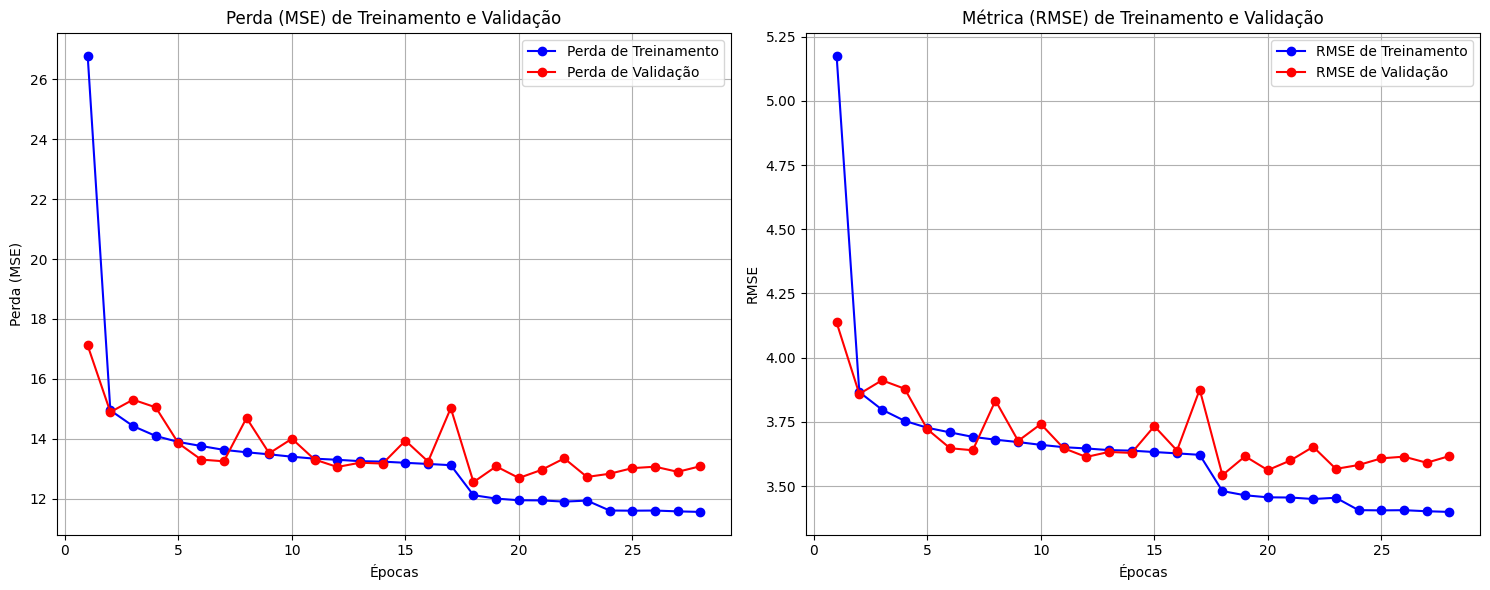

In [29]:
plot_training_history(history)

In [30]:
def predict_with_transformer(config, model):
    """Gera previsões e o arquivo de submissão usando o modelo Transformer."""
    
    # ... [COLE AQUI A LÓGICA PARA CARREGAR E PROCESSAR OS DADOS DE TESTE] ...
    # O resultado deve ser: X_enc_test, play_identifiers

    print("Iniciando previsões com o modelo Transformer...")
    predictions = []

    for i in range(len(X_enc_test)):
        input_seq = X_enc_test[i:i+1]
        
        # Inicia o decoder com um token de 'start' (um único passo de tempo com zeros)
        decoder_input = np.zeros((1, 1, 2)) # (batch, seq_len, features)
        
        num_frames_to_predict = play_identifiers[i][3]
        
        for _ in range(num_frames_to_predict):
            # Faz a previsão
            pred = model.predict([input_seq, decoder_input], verbose=0)
            
            # Pega o último ponto previsto
            next_coord = pred[:, -1:, :] # Pega o último passo da sequência
            
            # Concatena o ponto previsto à entrada do decoder para a próxima iteração
            decoder_input = tf.concat([decoder_input, next_coord], axis=1)

        # A saída final é a sequência gerada pelo decoder (ignorando o token de start)
        output_sequence = decoder_input.numpy()[0, 1:, :]
        predictions.append(output_sequence)